In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


In [2]:
# Set device (GPU if available)
device = "mps"  # torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
batch_size = 128
learning_rate = 1e-3
num_epochs = 10
latent_dim = 2  # Reduce to 2 dimensions


In [3]:
# MNIST dataset
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(
    root="./data", train=True, transform=transform, download=True
)
test_dataset = datasets.MNIST(
    root="./data", train=False, transform=transform, download=True
)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


In [4]:
# VAE model
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()

        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 512), nn.ReLU(), nn.Linear(512, 128), nn.ReLU()
        )
        # Mean and log-variance for latent variables
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_logvar = nn.Linear(128, latent_dim)

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, 28 * 28),
            nn.Sigmoid(),  # Output pixel values between 0 and 1
        )

    def reparameterize(self, mu, logvar):
        # Reparameterization trick for backpropagation through stochastic variables
        std = torch.exp(0.5 * logvar)  # Standard deviation
        eps = torch.randn_like(std).to(device)  # Random normal tensor
        return mu + eps * std  # Sample from the distribution

    def forward(self, x):
        # Encode input to latent space
        x = x.view(-1, 28 * 28)  # Flatten image
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        z = self.reparameterize(mu, logvar)  # Sample latent variable

        # Decode latent variable back to image
        reconstructed_x = self.decoder(z)
        reconstructed_x = reconstructed_x.view(-1, 1, 28, 28)  # Reshape to image

        return reconstructed_x, mu, logvar


In [5]:
# Loss function (combines reconstruction loss and KL divergence)
def loss_function(recon_x, x, mu, logvar):
    # Reconstruction loss (binary cross-entropy)
    BCE = nn.functional.binary_cross_entropy(
        recon_x.view(-1, 28 * 28), x.view(-1, 28 * 28), reduction="sum"
    )
    # KL divergence between the learned latent distribution and standard normal distribution
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    # Total loss
    return BCE + KLD


In [6]:
# Initialize model and optimizer
model = VAE(latent_dim=latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
model.train()
for epoch in range(num_epochs):
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()

        # Forward pass
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)

        # Backward pass and optimization
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(
                "Epoch [{}/{}] Batch [{}/{}] Loss: {:.4f}".format(
                    epoch + 1,
                    num_epochs,
                    batch_idx,
                    len(train_loader),
                    loss.item() / len(data),
                )
            )

    average_loss = train_loss / len(train_loader.dataset)
    print("====> Epoch: {} Average loss: {:.4f}".format(epoch + 1, average_loss))


Epoch [1/10] Batch [0/469] Loss: 546.5319
Epoch [1/10] Batch [100/469] Loss: 194.5961
Epoch [1/10] Batch [200/469] Loss: 165.1409
Epoch [1/10] Batch [300/469] Loss: 175.6385
Epoch [1/10] Batch [400/469] Loss: 166.2430
====> Epoch: 1 Average loss: 185.0254
Epoch [2/10] Batch [0/469] Loss: 158.4152
Epoch [2/10] Batch [100/469] Loss: 158.3771
Epoch [2/10] Batch [200/469] Loss: 167.8865
Epoch [2/10] Batch [300/469] Loss: 158.5326
Epoch [2/10] Batch [400/469] Loss: 161.2129
====> Epoch: 2 Average loss: 161.5878
Epoch [3/10] Batch [0/469] Loss: 153.9181
Epoch [3/10] Batch [100/469] Loss: 157.5078
Epoch [3/10] Batch [200/469] Loss: 153.6426
Epoch [3/10] Batch [300/469] Loss: 158.2157
Epoch [3/10] Batch [400/469] Loss: 152.9639
====> Epoch: 3 Average loss: 156.0663
Epoch [4/10] Batch [0/469] Loss: 159.4762
Epoch [4/10] Batch [100/469] Loss: 156.6038
Epoch [4/10] Batch [200/469] Loss: 156.8989
Epoch [4/10] Batch [300/469] Loss: 149.9076
Epoch [4/10] Batch [400/469] Loss: 150.0412
====> Epoch: 4

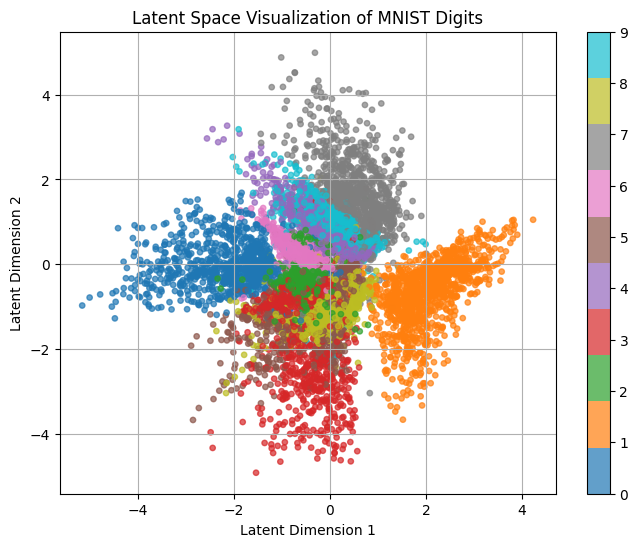

In [7]:
# Visualization of the latent space
model.eval()
with torch.no_grad():
    z_list = []
    label_list = []
    for data, labels in test_loader:
        data = data.to(device)
        data = data.view(-1, 28 * 28)
        h = model.encoder(data)
        mu = model.fc_mu(h)
        # Use the mean (mu) of the latent space for visualization
        z = mu.cpu().numpy()
        z_list.append(z)
        label_list.append(labels.numpy())

# Concatenate all latent variables and labels
z_all = np.concatenate(z_list)
labels_all = np.concatenate(label_list)

# Plot the latent space
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    z_all[:, 0], z_all[:, 1], c=labels_all, cmap="tab10", alpha=0.7, s=15
)
plt.colorbar()
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.title("Latent Space Visualization of MNIST Digits")
plt.grid(True)
plt.show()